In [40]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import timedelta as td
import pytrends
from pytrends.request import TrendReq

In [41]:
#sales milestones
#starts scenario on todays date to keep it current
start = (pd.to_datetime('today')).strftime("%Y-%m-%d")
contract_signed = pd.to_datetime(start) + pd.DateOffset(months=3)
#construction was state to take three months an additional three months for permitting and another 3 month buffer
construction_end = pd.to_datetime(contract_signed) + pd.DateOffset(months=9)
#pandemic has be quoted to last 18 months by St. Louis Federal Reserve and Bill Gates Foundation
social_distancing = pd.to_datetime(construction_end)  + pd.DateOffset(months=3)
#Low End Sales
low_sales = pd.to_datetime(construction_end) + pd.DateOffset(months=6)
#Medium Sales
medium_sales = pd.to_datetime(low_sales) + pd.DateOffset(months=12)
#High End Sales
high_sales = pd.to_datetime(medium_sales) + pd.DateOffset(months=24)
#Full Sales to End of Scenario Run
end = pd.to_datetime(contract_signed) + pd.DateOffset(months=84)

def milestone_col(df,x):
    df = df.copy(deep=True)
    df['Milestone'] = np.where(df[x]<=contract_signed,
                               start,
                               np.where(df[x]<=construction_end,
                                        contract_signed,
                                        np.where(df[x]<=social_distancing,
                                                 construction_end,
                                                 np.where(df[x]<=low_sales,
                                                          social_distancing,
                                                          np.where(df[x]<=medium_sales,
                                                                   low_sales,
                                                                   np.where(df[x]<=high_sales,
                                                                                     medium_sales,
                                                                                     np.where(df[x]<=end,
                                                                                              high_sales,end)))))))
    df['Sales MM'] = np.where(df[x]<=contract_signed,
                               0,
                               np.where(df[x]<=construction_end,
                                        0,
                                        np.where(df[x]<=social_distancing,
                                                 0,
                                                 np.where(df[x]<=low_sales,
                                                          0.33,
                                                          np.where(df[x]<=medium_sales,
                                                                   0.65,
                                                                   np.where(df[x]<=high_sales,
                                                                                     0.75,
                                                                                     np.where(df[x]<=end,
                                                                                              0.95,1.0)))))))
    return df
def datetime_cols(df,x):
    df['year'] = pd.to_datetime(df[x]).dt.to_period('Y')
    df['month'] = pd.to_datetime(df[x]).dt.month
    df['week'] = pd.to_datetime(df[x]).dt.week
    return df

In [42]:
#Load Google Trends
pytrend = TrendReq()
#Look up Google Trends for these in our Comp Set
pytrend.build_payload(kw_list=['4th Street Vine',
                               'Ambitious Ales',
                               'Beachwood BBQ and Brewing',	
                               'Congregation Ale House',
                               'Little Vice'], 
                      timeframe='today 5-y', geo = 'US-CA')
#@title
#PyTrend to Dataframe
interest_over_time_df = pytrend.interest_over_time()
interest_over_time_df = interest_over_time_df.reset_index()
#Date Meta Info
interest_over_time_df = datetime_cols(interest_over_time_df,'date')
#Google Trends Dataframe forming
interest_over_time_df = interest_over_time_df.rename_axis("Comp Set", axis="columns")
interest_over_time_df = interest_over_time_df
interest_over_time_df = interest_over_time_df.set_index(['date','year','month','week','isPartial'])
interest_over_time_df = interest_over_time_df.stack().to_frame()
interest_over_time_df = interest_over_time_df.rename(columns={0: 'Interest'})
# interest_over_time_df
# month
interest_month = interest_over_time_df.groupby('month').mean()
interest_month['Mean'] = interest_month['Interest'].mean()
interest_month['Weight_m'] = interest_month['Interest']/interest_month['Mean']
interest_month = interest_month['Weight_m']
interest_month = interest_month.to_frame()
# week
interest_week = interest_over_time_df.groupby('week').mean()
interest_week['Mean'] = interest_week['Interest'].mean()
interest_week['Weight_w'] = interest_week['Interest']/interest_week['Mean']
interest_week = interest_week['Weight_w']
interest_week = interest_week.to_frame()
# interest_month

In [43]:
rent = [
        [1,2.50,0],
        [2,0,500],
        [10,2.50,0],
        [21,2.58,0],
        [33,2.65,0],
        [45,2.73,0],
        [57,2.81,0],
       ]
sqft = 1245
rent = pd.DataFrame(rent, columns=['Month','$/sqft','Fee']).set_index('Month')
rent['Rent'] = (rent['$/sqft']*sqft)+rent['Fee']
rent = rent.reindex(range(1,85), fill_value=np.nan).ffill().reset_index().drop(columns=['$/sqft','Fee','Month']) * -1
rent['Date'] = pd.date_range(start=contract_signed,end=end,freq='MS')
rent = rent.set_index('Date')
rent.head(30)


,Rent
Date,
2021-07-01,-3112.5
2021-08-01,-500.0
2021-09-01,-500.0
2021-10-01,-500.0
2021-11-01,-500.0
2021-12-01,-500.0
2022-01-01,-500.0
2022-02-01,-500.0
2022-03-01,-500.0


In [44]:
#https://docs.google.com/spreadsheets/d/1ZNJS_r8v2ujl46iEEzWmzmdxPEk0ocqqazSF7yb5iwU/edit#gid=1956651536&range=B1
startup_costs = [[6200,'Materials','NEW Cold Box'],
[3500,'Materials','Cold Box Rack Installation'],
[0,'Materials','Ryans Old Fridge'],
[3000,'Materials','Tap System'],
[250,'Design','Fridge Labels'],
[5000,'Design','Bar'],
[4000,'Design','Chairs'],
[4000,'Design','Tables'],
[1000,'Design','Draft Marquee'],
[1000,'Design','Taps and Lines'],
[7000,'Product','Bottles / Cans'],
[4000,'Product','Kegs'],
[5000,'Product','Glassware'],
[20000,'Construction','Ramp & 1? ADA Bathroom'],
[16000,'Permitting','CUP'],
[8000,'Materials','two totes/fermentors'],
[3000,'Materials','24" Prep Table w/ cold storage '],
[2000,'Materials ','Kitchen Fridge'],
[200,'','Prep Table '],
[300,'','Storage Shelves '],
[2000,'','Panini Press x 2 '],
[700,'','Ooni Pro Pizza Oven'],
[500,'','Serving Dishes'],
[1000,'','Prep Dishes / Food Storage'],
[6000,'','Dishwasher '],
[3000,'','Crowler Machine ']]
startup_pd = pd.DataFrame(startup_costs, 
                         columns = ['Cost', 'Category', 'Item'])
startup_pd

,Cost,Category,Item
0,6200,Materials,NEW Cold Box
1,3500,Materials,Cold Box Rack Installation
2,0,Materials,Ryans Old Fridge
3,3000,Materials,Tap System
4,250,Design,Fridge Labels
5,5000,Design,Bar
6,4000,Design,Chairs
7,4000,Design,Tables
8,1000,Design,Draft Marquee
9,1000,Design,Taps and Lines


In [45]:
#creates a employee table to calculate hours for weekdays and weekends
living_wage = -15 #/hr
benefits = .36 #percent of total salary
payroll_tax = .15 #percent of total salary
employees = [['Ryan', 40, construction_end], 
             ['Doug', 40, construction_end], 
             ['Graham', 40, construction_end], 
             ['Kyle', 40, construction_end], 
             ['Employee 1', 28, social_distancing], #low_sales
             ['Employee 2', 35, medium_sales],#This employee works half shift all days
             ['Employee 3', 28, high_sales],
             ['Employee 4', 35, high_sales]] 
workforce = pd.DataFrame(employees, 
                         columns = ['Employee', 'Salary','Start Date'])
weekly_salary = (workforce.groupby(['Start Date'])['Salary'].sum()*living_wage).cumsum().reset_index().set_index('Start Date')
weekly_salary = weekly_salary#.to_dict('index')
weekly_salary

,Salary
Start Date,
2022-03-14,-2400
2022-06-14,-2820
2023-09-14,-3345
2025-09-14,-4290


In [46]:
payroll = pd.DataFrame(pd.date_range(start=construction_end,end=end,freq='W-FRI'),columns=['Date'])
payroll = milestone_col(payroll,'Date')
payroll = payroll.merge(weekly_salary,left_on=['Milestone'],right_on=['Start Date'],how='left')
payroll = payroll.drop(columns=['Milestone']).set_index('Date')
payroll

,Sales MM,Salary
Date,,
2022-03-18,0.00,-2400.0
2022-03-25,0.00,-2400.0
2022-04-01,0.00,-2400.0
2022-04-08,0.00,-2400.0
2022-04-15,0.00,-2400.0
...,...,...
2028-05-12,0.95,-4290.0
2028-05-19,0.95,-4290.0
2028-05-26,0.95,-4290.0


In [47]:
# https://www.salestaxhandbook.com/california/rates/long-beach
sales_tax = .1025
# https://www.calrecycle.ca.gov/bevcontainer/retailers/crvreceipts
crv = .05
#function distributes total average transaction totals to the parent category
parentCategory = [['Bottles', 0.2], 
                  ['Packs', 0.07], 
                  ['Draught', 0.7], 
                  ['Merch', 0.03]] 
pCategory = pd.DataFrame(parentCategory, columns = ['Parent Category', 'Mix'])
#fucntion further distributes total average transaction totals to the category
inventoryBreakdown = [ ['Good Bottles ($6-8**)','Bottles',0.65,0.5,7],
                      ['Great Bottles ($9-12**)','Bottles',0.2,0.5,10.5],
                      ['Nice Bottles ($13-18**)','Bottles',0.1,0.5,15],
                      ['Rare Bottles ($18-25**)','Bottles',0.04,0.5,20],
                      ['Super Rare Bottles ($25+**)','Bottles',0.01,0.4444,25],
                      ['6 Packs','Packs',0.7222,0.5,12.3],
                      ['4 Packs','Packs',0.2778,0.5,10],
                      ['16oz Draught','Draught',0.3,0.25,6],
                      ['12oz Draught Pours','Draught',0.3,0.25,6],
                      ['4oz Draught (Taster)','Draught',0.4,0.25,2],
                      ['T-Shirts','Merch',0.2857,0.35,15],
                      ['Glassware','Merch',0.1429,0.5,5],
                      ['Packaged Goods','Merch',0.5714,0.5,6]
]
inventory = pd.DataFrame(inventoryBreakdown, columns = ['Category', 'Parent Category','Mix','Cost Margin','Price'])
#add category table and parent category together
inventory = pd.merge(left=inventory, 
                     right=pCategory, 
                     how='left', 
                     left_on='Parent Category', 
                     right_on='Parent Category')
inventory.groupby('Parent Category')['Mix_x'].sum()
inventory = inventory.set_index('Category')
inventory['CRV'] =  np.where((inventory['Parent Category'] == 'Bottles'), crv,  #when... then
                        np.where((inventory.index == '4 Packs'), crv*4,  #when... then
                        np.where((inventory.index == '6 Packs'), crv*6,  #when... then
                        0)))
inventory['Sales Tax'] = inventory['Price'] * sales_tax
inventory['Profit'] = (inventory['Price']*(1-inventory['Cost Margin']))+(inventory['CRV'] + inventory['Sales Tax'])
inventory = inventory
inventory = inventory

#figures out metrics to guide realistic sales figures
# Weekday 9 Hours Based on 3PM - 10PM
# Weekend 12 Hours Based on Noon - 11PM
avg_items_sold = 400
avgDailyTransactions = [['Weekdays', avg_items_sold,7], 
                        ['Weekends', avg_items_sold * 2,11]] 
avgDaily = pd.DataFrame(avgDailyTransactions, columns = ['Day Type', 'Total Transactions', 'Hours']).set_index('Day Type')
avgDaily['Per Hour'] = avgDaily['Total Transactions'] / avgDaily['Hours'] 
avgDaily['Per Minute'] = avgDaily['Per Hour'] / 60
inventory

,Parent Category,Mix_x,Cost Margin,Price,Mix_y,CRV,Sales Tax,Profit
Category,,,,,,,,
Good Bottles ($6-8**),Bottles,0.6500,0.5000,7.0,0.20,0.05,0.71750,4.26750
Great Bottles ($9-12**),Bottles,0.2000,0.5000,10.5,0.20,0.05,1.07625,6.37625
Nice Bottles ($13-18**),Bottles,0.1000,0.5000,15.0,0.20,0.05,1.53750,9.08750
Rare Bottles ($18-25**),Bottles,0.0400,0.5000,20.0,0.20,0.05,2.05000,12.10000
Super Rare Bottles ($25+**),Bottles,0.0100,0.4444,25.0,0.20,0.05,2.56250,16.50250
6 Packs,Packs,0.7222,0.5000,12.3,0.07,0.30,1.26075,7.71075
4 Packs,Packs,0.2778,0.5000,10.0,0.07,0.20,1.02500,6.22500
16oz Draught,Draught,0.3000,0.2500,6.0,0.70,0.00,0.61500,5.11500
12oz Draught Pours,Draught,0.3000,0.2500,6.0,0.70,0.00,0.61500,5.11500


In [48]:
sales = milestone_col(pd.DataFrame(pd.date_range(start=construction_end,end=end,freq='D'),columns=['Date']),'Date')
sales = datetime_cols(sales,'Date')
sales = sales.merge(interest_month, on='month',how='left').merge(interest_week, on='week',how='left')
sales['Weight'] = (((sales['Weight_m']*.85) + (sales['Weight_w']*.15)) * sales['Sales MM'])
sales = sales.drop(columns=['Sales MM','year','month','week','Weight_m','Weight_w'])
sales['Daily Transactions'] = np.where((sales['Date'].dt.day_name() == 'Friday') | (sales['Date'].dt.day_name() == 'Saturday') | (sales['Date'].dt.day_name() == 'Sunday'),
                                       (avgDaily.loc['Weekends','Total Transactions']*sales['Weight']).apply(np.floor),
                                       (avgDaily.loc['Weekdays','Total Transactions']*sales['Weight']).apply(np.floor))

for sales_cat_col in inventory.index:
    sales[sales_cat_col] = (sales['Daily Transactions']*((inventory.loc[sales_cat_col,'Mix_x']*inventory.loc[sales_cat_col,'Mix_y'])))*inventory.loc[sales_cat_col,'Profit']
sales = sales.drop(columns=['Milestone','Weight']).set_index('Date')
sales = sales.drop(columns=['Daily Transactions'])
sales["Profit"] = sales.sum(axis=1)
sales

,Good Bottles ($6-8**),Great Bottles ($9-12**),Nice Bottles ($13-18**),Rare Bottles ($18-25**),Super Rare Bottles ($25+**),6 Packs,4 Packs,16oz Draught,12oz Draught Pours,4oz Draught (Taster),T-Shirts,Glassware,Packaged Goods,Profit
Date,,,,,,,,,,,,,,
2022-03-14,0.00000,0.0000,0.0000,0.0000,0.00000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000
2022-03-15,0.00000,0.0000,0.0000,0.0000,0.00000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000
2022-03-16,0.00000,0.0000,0.0000,0.0000,0.00000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000
2022-03-17,0.00000,0.0000,0.0000,0.0000,0.00000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000
2022-03-18,0.00000,0.0000,0.0000,0.0000,0.00000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028-06-10,352.83690,162.2118,115.5930,61.5648,20.99118,247.918686,76.988659,683.1594,683.1594,303.6264,61.529923,8.213678,39.411858,2817.205684
2028-06-11,352.83690,162.2118,115.5930,61.5648,20.99118,247.918686,76.988659,683.1594,683.1594,303.6264,61.529923,8.213678,39.411858,2817.205684
2028-06-12,167.54205,77.0251,54.8885,29.2336,9.96751,117.722395,36.557508,324.3933,324.3933,144.1748,29.217039,3.900205,18.714436,1337.729743


In [49]:
upcoming = [
            ['Startup',-startup_pd['Cost'].sum(),'One Time',[start],np.nan,0],
            ['Rent',np.nan,'Custom',rent,np.nan,0], #Custom loads custom list
            ['Utilties',-750,'Monthly',5,np.nan,0],
            ['Maintenance',-1000,'Monthly',15,np.nan,0],
            ['Marketing',-2000,'Monthly',10,np.nan,0],
            ['Salary',np.nan,'Custom',payroll,np.nan,0],
            ['Benefits',['Salary',.36],'Multiplier',np.nan,np.nan,0],
            ['Payroll Tax',['Salary',.15],'Multiplier',np.nan,np.nan,0],
            ['Profit',np.nan,'Custom',sales['Profit'].reset_index().set_index('Date'),np.nan,0],
            ['Unknown',-2000,'Monthly',8,5,24]
    
           ]
upcoming = pd.DataFrame(upcoming,columns=['Transaction Name','Amount','Frequency','On','Interval','Offset']).set_index('Transaction Name')
upcoming

,Amount,Frequency,On,Interval,Offset
Transaction Name,,,,,
Startup,-106650,One Time,[2021-03-14],NaN,0
Rent,NaN,Custom,Rent Date 2021-0...,NaN,0
Utilties,-750,Monthly,5,NaN,0
Maintenance,-1000,Monthly,15,NaN,0
Marketing,-2000,Monthly,10,NaN,0
Salary,NaN,Custom,Sales MM Salary Date ...,NaN,0
Benefits,"[Salary, 0.36]",Multiplier,NaN,NaN,0
Payroll Tax,"[Salary, 0.15]",Multiplier,NaN,NaN,0
Profit,NaN,Custom,Profit Date ...,NaN,0


In [50]:
df = pd.DataFrame(pd.date_range(start,end,freq='d'),columns=['Date'])
for transactions_col in upcoming.index:
    if upcoming.loc[transactions_col,'Frequency'] == 'Monthly':
        df[transactions_col] = np.where(df['Date'].isin(pd.date_range(start=start, end=end, freq='MS')+pd.DateOffset(days=upcoming.loc[transactions_col,'On']-1))==True,
                                        upcoming.loc[transactions_col,'Amount'],
                                        np.nan)
    elif upcoming.loc[transactions_col,'Frequency'] == 'Custom':
        df = df.merge(upcoming.loc[transactions_col,'On'],on=['Date'],how='left')
    elif upcoming.loc[transactions_col,'Frequency'] == 'One Time':
        df[transactions_col] = np.where(df['Date'].isin(upcoming.loc[transactions_col,'On']),
                                        upcoming.loc[transactions_col,'Amount'],
                                        np.nan)
    elif upcoming.loc[transactions_col,'Frequency'] == 'Multiplier':
        df[transactions_col] = np.where(df[upcoming.loc[transactions_col,'Amount'][0]]!=np.nan,
                                        df[upcoming.loc[transactions_col,'Amount'][0]] * upcoming.loc[transactions_col,'Amount'][1],
                                        np.nan)
    else:
        df[transactions_col] = np.nan
df["Total"] = df.sum(axis=1)
df["Total cumsum"] = df["Total"].cumsum()
df#.tail(50)#.info()

,Date,Startup,Rent,Utilties,Maintenance,Marketing,Sales MM,Salary,Benefits,Payroll Tax,Profit,Unknown,Total,Total cumsum
0,2021-03-14,-106650.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-106650.000000,-1.066500e+05
1,2021-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-1.066500e+05
2,2021-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-1.066500e+05
3,2021-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-1.066500e+05
4,2021-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-1.066500e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2645,2028-06-10,NaN,NaN,NaN,NaN,-2000.0,NaN,NaN,NaN,NaN,2817.205684,NaN,817.205684,2.057931e+06
2646,2028-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2817.205684,NaN,2817.205684,2.060748e+06
2647,2028-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1337.729743,NaN,1337.729743,2.062086e+06
2648,2028-06-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1337.729743,NaN,1337.729743,2.063423e+06


In [51]:
2021454.25 / 2647
# (end - pd.to_datetime(start))

763.677465054779

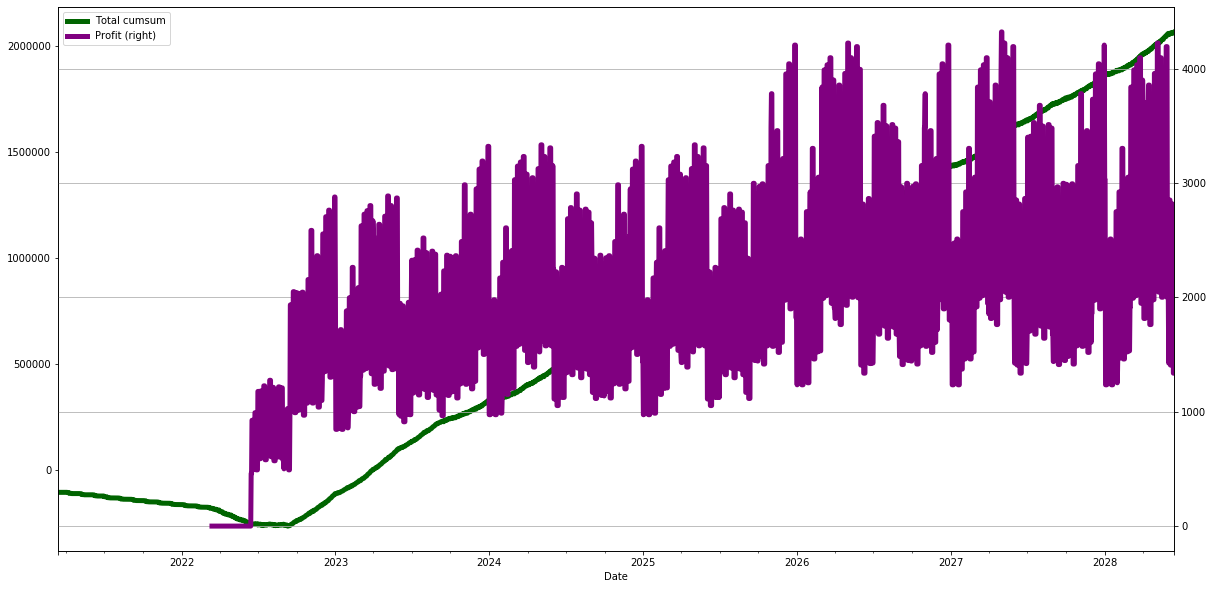

In [52]:
df.plot(kind='line',x='Date',y=['Total cumsum',
                                'Profit'], color=['darkgreen','purple']
        ,secondary_y=['Profit']
        ,figsize=(20,10),linewidth=5,
       )
plt.grid()